<a href="https://colab.research.google.com/github/sodiq-sulaimon/Preparations-for-TensorFlow-Developer-Certification/blob/main/Time_Series/Training_a_Deep_Neural_Network_with_Time_Series_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### Utilities

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series


def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

### Generate synthethic data

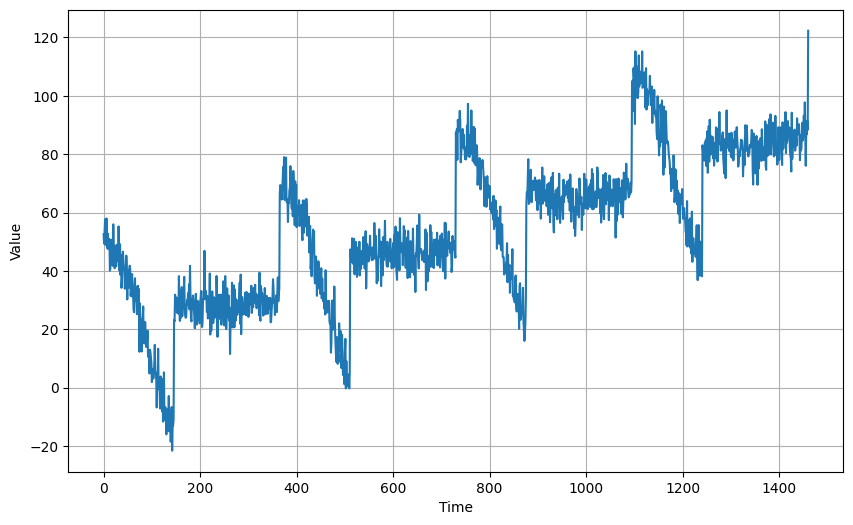

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype='float32')
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

### Split the dataset

In [4]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

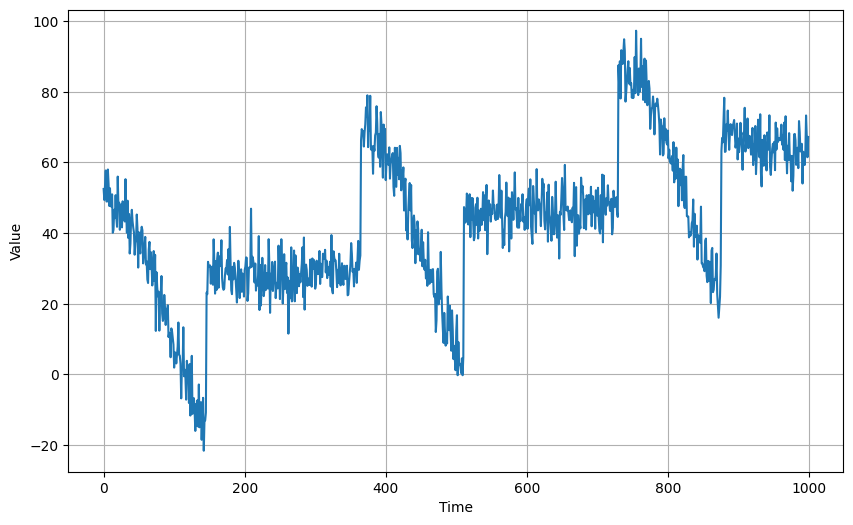

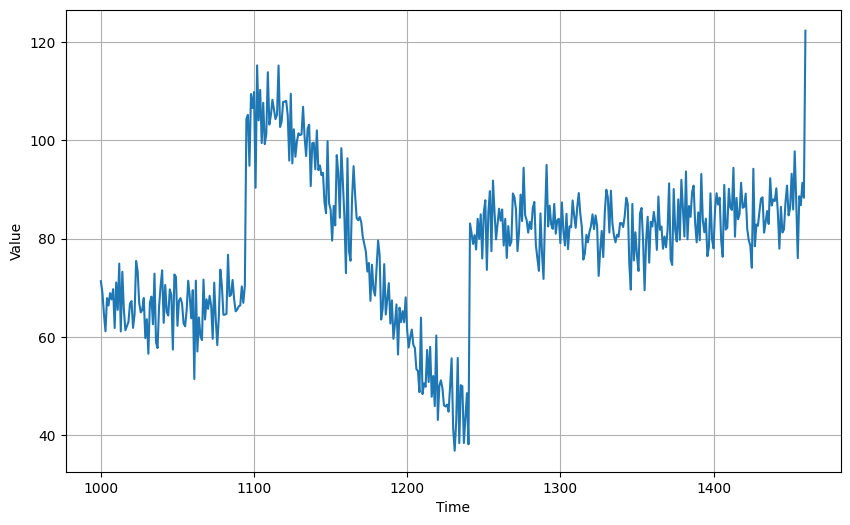

In [5]:
# Plot the data
plot_series(time_train, x_train)

plot_series(time_valid, x_valid)

### Prepare features and labels

In [6]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
    # Generate a tf dataset from the series
  dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) # There is a + 1 to indicate that you're taking the next point as the label

  # Flatten the windows by putting the elements in a single batch
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  # Create tuples with features and labels
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))

  # Shuffle the windows
  dataset = dataset.shuffle(shuffle_buffer)

  # Create batches of windows
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

Now we can generate the dataset windows from the train set.

In [8]:
dataset = windowed_dataset(x_train, window_size,batch_size,shuffle_buffer_size)

In [9]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')


data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


### Build and compile the model
We will assign the layer to a variable l0 so we can also look at the final weights later using the get_weights() method.

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
    ])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 10)                210       
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 331 (1.29 KB)
Trainable params: 331 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

### Train the model

In [14]:
model.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 6s 3ms/step - loss: 821.5738
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 128.3383
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 98.3558
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 90.8097
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 84.7808
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 80.2766
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 77.0778
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 72.5158
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 69.4464
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 67.4851
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 65.0787
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 64.0306
Epoch 13/100
31/31 [===

### Model Prediction

1/1 [==============================] - 0s 17ms/step


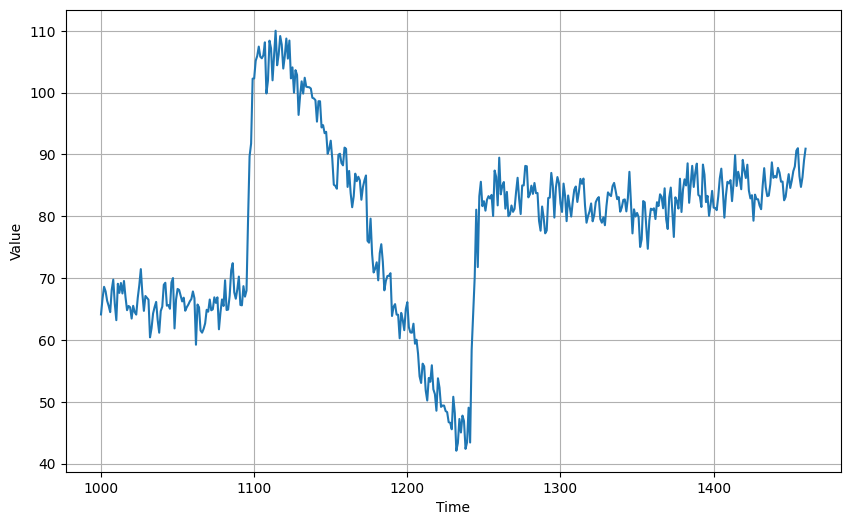

In [17]:
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

plot_series(time_valid, results)

In [20]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

46.136955
5.0604405


### Tune the learning rate

In [36]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20))

In [37]:
# Recompile the model
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(momentum=0.9))

In [38]:
# Retrain the model
history = model.fit(dataset, epochs=100, callbacks=[lr_scheduler])

Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 810.6671 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 470.9501 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 288.7385 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 224.3528 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 208.5300 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 203.9624 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 201.3506 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 198.8382 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 196.2449 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 193.1658 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 300.0)

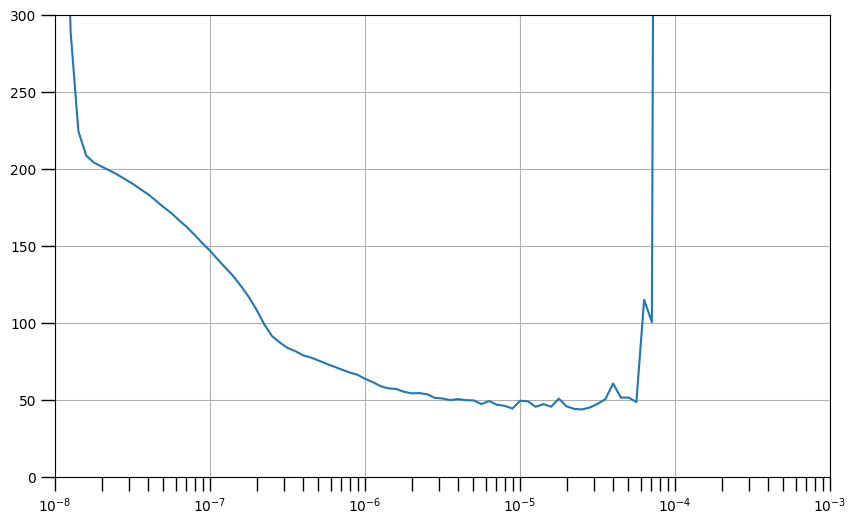

In [39]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 300])

Use the information from the learning rate plot to recompile and train the model. We will choose learning rate 4e-6 (0.000040)

In [41]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
    ])

model2.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=4e-6, momentum=0.9))

In [42]:
history = model2.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 6ms/step - loss: 349.8446
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 100.7004
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 89.9206
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 83.7065
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 77.2595
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 73.2787
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 69.2845
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 67.5232
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 65.3471
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 63.1911
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 65.2598
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 67.1714
Epoch 13/100
31/31 [===

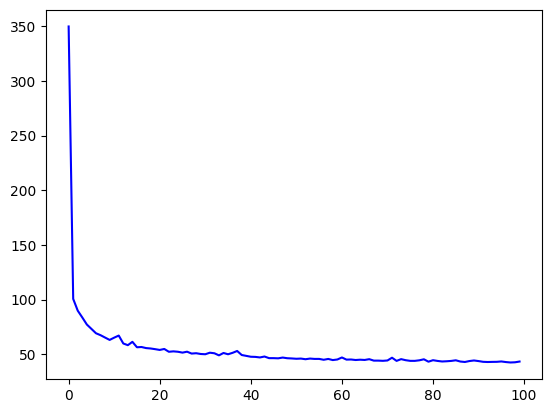

In [43]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

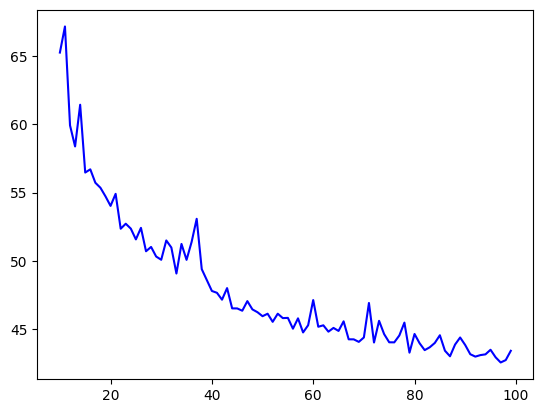

In [44]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

1/1 [==============================] - 0s 18ms/step


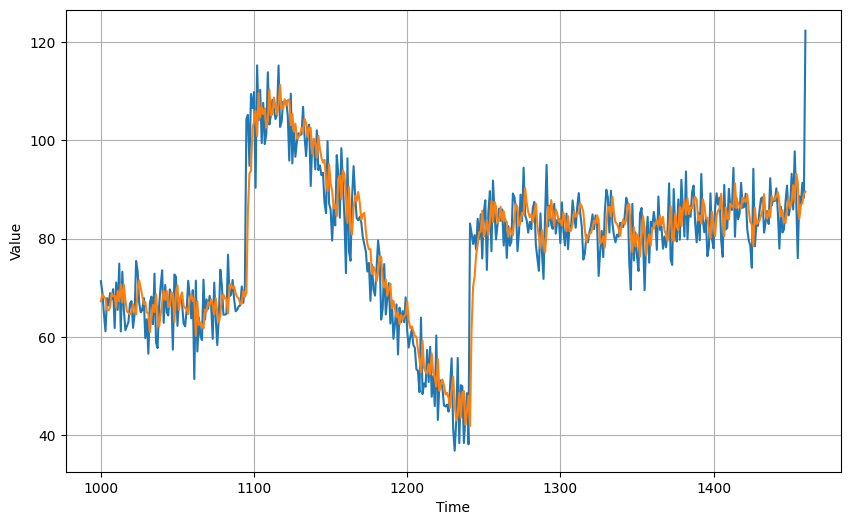

In [46]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model2.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [47]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

44.970352
5.0547447
